In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sc.settings.verbosity = 3
sns.set(font="Arial", font_scale=1.2, style='ticks')
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#104e8b", "#ffdab9", "#8b0a50"])
cmap4 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#191970", "#ffdab9", "#8B0000"])

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)

In [2]:
# Clinical information
clinic_info = pd.read_csv('/data/Projects/phenomata/01.Projects/08.StomachCancer_backup/2022_WC300_clinical_information_Xadded.csv', index_col='Sample')
#clinic_info = pd.read_csv('/home/mhryan/Workspace/02.Projects/02.WC300/2022_WC300_clinical_information_Xadded.csv', index_col='Sample')


# RNA expression processing
## Combat-corrected gene-level VST
gene_vst = pd.read_table("/data/Projects/phenomata/01.Projects/08.StomachCancer_backup/02.RNA-seq/GENCODE_V24/STAD_SNUH_vst_ComBat.txt", index_col=0, sep=' ')
#gene_vst = pd.read_table("/home/mhryan/Workspace/02.Projects/02.WC300/02.RNA-seq/STAD_SNUH_vst_ComBat.txt", index_col=0, sep=' ')
gene_vst.columns = list(map(lambda x: 'X'+x, gene_vst.columns))

## DEG results from DESeq2
deg_tn = pd.read_csv("/data/Projects/phenomata/01.Projects/08.StomachCancer_backup/02.RNA-seq/GENCODE_V24/Tumor.Normal.compare_ComBat.csv", index_col=0)
#deg_tn = pd.read_csv("/home/mhryan/Workspace/02.Projects/02.WC300/02.RNA-seq/Tumor.Normal.compare_ComBat.csv", index_col=0)
#deg_tn = deg_tn[deg_tn.index.isin(list(map(lambda x: x.split('/')[2], pls.index)))]

deg_genes = deg_tn[(deg_tn['padj'] < 0.01) & (deg_tn['baseMean'] > 10)].index

## Combat-corrected transcript-level counts
#trans_combat = pd.read_table("/data/Projects/phenomata/01.Projects/08.StomachCancer_backup/02.RNA-seq/GENCODE_V24/STAD_SNUH_tx_combat_counts.txt", index_col=0, sep=' ')
trans_combat = pd.read_table("/data/Projects/phenomata/01.Projects/08.StomachCancer_backup/02.RNA-seq/GENCODE_V24/STAD_SNUH_tx_combat_norm_counts.txt", index_col=0, sep=' ')
#trans_combat = pd.read_table("/home/mhryan/Workspace/02.Projects/02.WC300/02.RNA-seq/STAD_SNUH_tx_combat_norm_counts.txt", index_col=0, sep=' ')
trans_combat.columns = list(map(lambda x: 'X'+x, trans_combat.columns))


## Combat-corrected transcript-level log2(counts+1)
trans_combat_log2 = np.log2(trans_combat + 1)


## ENSEMBL transcript ID to GeneID table
tx2gene = pd.read_table("/data/Projects/phenomata/01.Projects/08.StomachCancer_backup/02.RNA-seq/GENCODE_V24/txdb_geneSymbol.txt")
#tx2gene = pd.read_table("/home/mhryan/Workspace/02.Projects/02.WC300/02.RNA-seq/txdb_geneSymbol.txt")

# Promoter methylation processing

## PLS info
pls_info = pd.read_table("PLS_annotated_table_full.txt", index_col=0)
## PLS info with DMR
plsdmr_info = pd.read_table("PLS_annotated_table_full_DMR.txt", index_col=0)
## NO-PLS info
nopls_info = pd.read_table("No_PLS_annotated_table_full.txt", index_col=0)
## NO-PLS info with DMR
noplsdmr_info = pd.read_table("No_PLS_annotated_table_full_DMR.txt", index_col=0)

## Gene-biotype used downstream
used_info = ['protein_coding',
             'lincRNA',
             '3prime_overlapping_ncRNA',
             'antisense',
             'bidirectional_promoter_lncRNA',
             'macro_lncRNA',
             'non_coding',
             'processed_transcript',
             'sense_intronic',
             'sense_overlapping']
pls_info = pls_info[pls_info['Type'].isin(used_info)]
nopls_info = nopls_info[nopls_info['Type'].isin(used_info)]
nopls_info = nopls_info[~nopls_info['GeneID'].isin(pls_info['GeneID'])]

plsdmr_info = plsdmr_info[plsdmr_info['Type'].isin(used_info)]
noplsdmr_info = noplsdmr_info[noplsdmr_info['Type'].isin(used_info)]
noplsdmr_info = noplsdmr_info[~noplsdmr_info['GeneID'].isin(plsdmr_info['GeneID'])]

pls = pd.read_table("cCRE_PLS_smooth_modified.txt", index_col=0)
nopls = pd.read_table("NO_PLS_smooth_modified.txt", index_col=0)
pls.columns = list(map(lambda x: 'X'+x, pls.columns))
nopls.columns = list(map(lambda x: 'X'+x, nopls.columns))
pls = pls[pls.index.isin(list(map(lambda x:'/'.join(x.split('/')[:-1]), pls_info.index)))]
nopls = nopls[nopls.index.isin(list(map(lambda x:'/'.join(x.split('/')[:-1]), nopls_info.index)))]

comb_pls = pd.concat([pls, nopls])
comb_pls_info = pd.concat([pls_info, nopls_info])
comb_pls.index = comb_pls_info.index

comb_plsdmr_info = pd.concat([plsdmr_info, noplsdmr_info])
comb_plsdmr = comb_pls[comb_pls.index.isin(comb_plsdmr_info.index)]
comb_plsdmr_info = comb_plsdmr_info[comb_plsdmr_info.index.isin(comb_plsdmr.index)]

del pls, nopls, pls_info, nopls_info


In [3]:
total1 = comb_plsdmr[comb_plsdmr.index.isin(comb_plsdmr_info[(comb_plsdmr_info['K4me3'] == 'Yes') & (comb_plsdmr_info['K27ac'] == 'Yes') & (comb_plsdmr_info['K27me3'] == 'Yes')].index)]
total2 = comb_plsdmr[comb_plsdmr.index.isin(comb_plsdmr_info[(comb_plsdmr_info['K4me3'] == 'Yes') & (comb_plsdmr_info['K27ac'] == 'Yes') & (comb_plsdmr_info['K27me3'] == 'na')].index)]
total3 = comb_plsdmr[comb_plsdmr.index.isin(comb_plsdmr_info[(comb_plsdmr_info['K4me3'] == 'Yes') & (comb_plsdmr_info['K27ac'] == 'na') & (comb_plsdmr_info['K27me3'] == 'Yes')].index)]
total4 = comb_plsdmr[comb_plsdmr.index.isin(comb_plsdmr_info[(comb_plsdmr_info['K4me3'] == 'Yes') & (comb_plsdmr_info['K27ac'] == 'na') & (comb_plsdmr_info['K27me3'] == 'na')].index)]
total5 = comb_plsdmr[comb_plsdmr.index.isin(comb_plsdmr_info[(comb_plsdmr_info['K4me3'] == 'na') & (comb_plsdmr_info['K27ac'] == 'Yes') & (comb_plsdmr_info['K27me3'] == 'na')].index)]
total6 = comb_plsdmr[comb_plsdmr.index.isin(comb_plsdmr_info[(comb_plsdmr_info['K4me3'] == 'na') & (comb_plsdmr_info['K27ac'] == 'na') & (comb_plsdmr_info['K27me3'] == 'Yes')].index)]
total7 = comb_plsdmr[comb_plsdmr.index.isin(comb_plsdmr_info[(comb_plsdmr_info['K4me3'] == 'na') & (comb_plsdmr_info['K27ac'] == 'na') & (comb_plsdmr_info['K27me3'] == 'na')].index)]


In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)

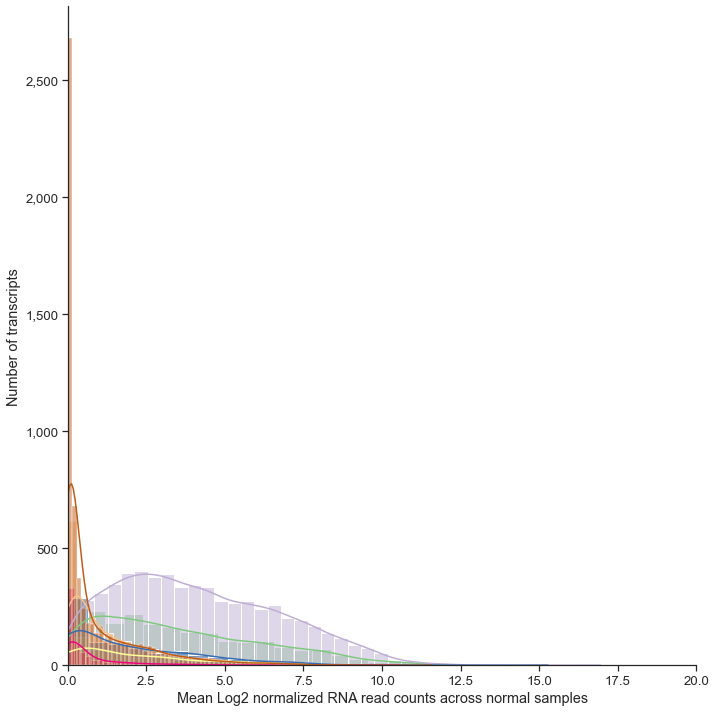

In [5]:
p = sns.histplot( trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total1.index)]['ENSTID'].values)) )], kde=True, stat='count', color=sns.color_palette("Accent", 7)[0])
p = sns.histplot( trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total2.index)]['ENSTID'].values)) )], kde=True, stat='count', color=sns.color_palette("Accent", 7)[1])
p = sns.histplot( trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total3.index)]['ENSTID'].values)) )], kde=True, stat='count', color=sns.color_palette("Accent", 7)[2])
p = sns.histplot( trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total4.index)]['ENSTID'].values)) )], kde=True, stat='count', color=sns.color_palette("Accent", 7)[3])
p = sns.histplot( trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total5.index)]['ENSTID'].values)) )], kde=True, stat='count', color=sns.color_palette("Accent", 7)[4])
p = sns.histplot( trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total6.index)]['ENSTID'].values)) )], kde=True, stat='count', color=sns.color_palette("Accent", 7)[5])
p = sns.histplot( trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total7.index)]['ENSTID'].values)) )], kde=True, stat='count', color=sns.color_palette("Accent", 7)[6])
p.set_xlabel("Mean Log2 normalized RNA read counts across normal samples")
p.set_ylabel("Number of transcripts")
sns.despine()
plt.xlim((0, 20))
#plt.xlim((0, 12))
plt.tight_layout()
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as ticker
p.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

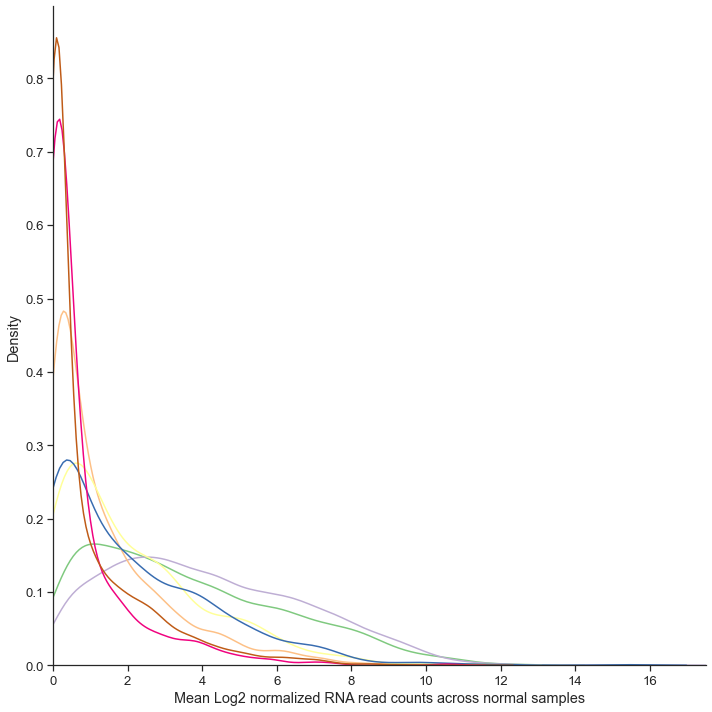

In [6]:
ax = plt.subplot(1,1,1)
sns.kdeplot(trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total1.index)]['ENSTID'].values)) )], color=sns.color_palette("Accent", 7)[0], fill=False, ax=ax)
sns.kdeplot(trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total2.index)]['ENSTID'].values)) )], color=sns.color_palette("Accent", 7)[1], fill=False, ax=ax)
sns.kdeplot(trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total3.index)]['ENSTID'].values)) )], color=sns.color_palette("Accent", 7)[2], fill=False, ax=ax)
sns.kdeplot(trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total4.index)]['ENSTID'].values)) )], color=sns.color_palette("Accent", 7)[3], fill=False, ax=ax)
sns.kdeplot(trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total5.index)]['ENSTID'].values)) )], color=sns.color_palette("Accent", 7)[4], fill=False, ax=ax)
sns.kdeplot(trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total6.index)]['ENSTID'].values)) )], color=sns.color_palette("Accent", 7)[5], fill=False, ax=ax)
sns.kdeplot(trans_combat_log2.iloc[:, :84].sum(axis=1).div(84)[trans_combat_log2.iloc[:, :84].sum(axis=1).div(84).index.isin( list(set(comb_plsdmr_info[comb_plsdmr_info.index.isin(total7.index)]['ENSTID'].values)) )], color=sns.color_palette("Accent", 7)[6], fill=False, ax=ax)
plt.xlim((0, 17.5))
ax.set_xlabel("Mean Log2 normalized RNA read counts across normal samples")
sns.despine()
plt.tight_layout()


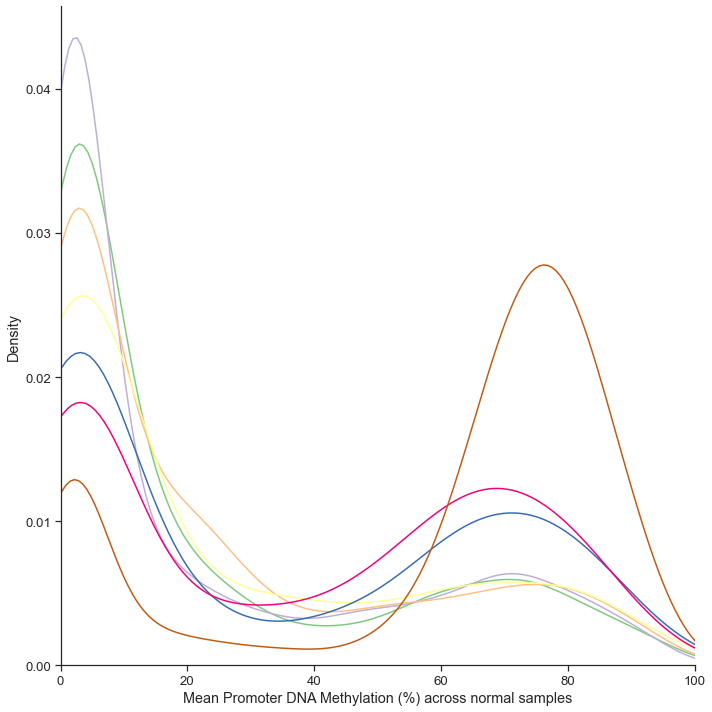

In [7]:
ax = plt.subplot(1,1,1)
sns.kdeplot(total1.iloc[:, :84].mean(axis=1)*100, color=sns.color_palette("Accent", 7)[0], ax=ax)
sns.kdeplot(total2.iloc[:, :84].mean(axis=1)*100, color=sns.color_palette("Accent", 7)[1], ax=ax)
sns.kdeplot(total3.iloc[:, :84].mean(axis=1)*100, color=sns.color_palette("Accent", 7)[2], ax=ax)
sns.kdeplot(total4.iloc[:, :84].mean(axis=1)*100, color=sns.color_palette("Accent", 7)[3], ax=ax)
sns.kdeplot(total5.iloc[:, :84].mean(axis=1)*100, color=sns.color_palette("Accent", 7)[4], ax=ax)
sns.kdeplot(total6.iloc[:, :84].mean(axis=1)*100, color=sns.color_palette("Accent", 7)[5], ax=ax)
sns.kdeplot(total7.iloc[:, :84].mean(axis=1)*100, color=sns.color_palette("Accent", 7)[6], ax=ax)
plt.xlim((0, 100))
ax.set_xlabel("Mean Promoter DNA Methylation (%) across normal samples")
sns.despine()
plt.tight_layout()